<a href="https://colab.research.google.com/github/mlelarge/graph_neural_net/blob/main/plot_accuracy_regular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# If running on Colab, uncomment the code below:
#!git clone https://github.com/mlelarge/graph_neural_net.git
#!pip install lightning
#%cd graph_neural_net

/content/graph_neural_net


In [2]:
import os
from pathlib import Path
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from models import get_siamese_model_test
import loaders.data_generator as dg
from loaders.loaders import siamese_loader
from toolbox.utils import check_dir
import loaders.data_generator as dg
from loaders.loaders import siamese_loader

ROOT_DIR = Path.home()
path_dataset = os.path.join(ROOT_DIR, 'data/')

from toolbox.metrics import all_losses_acc, accuracy_linear_assignment
from toolbox.losses import triplet_loss

criterion = triplet_loss()

# Downloading the pretrained model

The cell below should only be run once, it creates a folder `downloads/` and then downloads in this folder the pretrained model and the configuration file.

In [3]:
import requests
config_url = 'https://github.com/mlelarge/graph_neural_net/releases/download/v1-qap/config.json'
model_url = 'https://github.com/mlelarge/graph_neural_net/releases/download/v1-qap/epoch.98-step.7821.ckpt'
cwd = os.getcwd()
downloads = os.path.join(cwd, 'downloads')
check_dir(downloads)

r = requests.get(config_url)
with open(cwd+'/downloads/config.json', 'wb') as f:
    f.write(r.content)

r = requests.get(model_url)
with open(cwd+'/downloads/epoch.98-step.7821.ckpt', 'wb') as f:
    f.write(r.content)


In [4]:
name = cwd+'/downloads/epoch.98-step.7821.ckpt'
path = cwd+'/downloads/'

In [5]:
def get_device_config(path):
    config_file = os.path.join(path,'config.json')
    with open(config_file) as json_file:
        config_model = json.load(json_file)
    use_cuda = not config_model['cpu'] and torch.cuda.is_available()
    device = 'cuda' if use_cuda else 'cpu'
    return config_model, device

In [6]:
config_model, device = get_device_config(path)

In [7]:
model = get_siamese_model_test(name, config_model)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file downloads/epoch.98-step.7821.ckpt`


In [8]:
config_data = config_model['data']

In [9]:
num = 23
list_noise = np.linspace(0, 0.22, num=num)

In [10]:
def compute_all(list_noise,config_data,path_dataset,model,device,bs=32):
    all_acc = np.zeros((len(list_noise),config_data['test']['num_examples_test']))
    for i,noise in enumerate(list_noise):
        config_data['test']['noise']=noise
        gene_test = dg.QAP_Generator('test', config_data['test'], path_dataset)
        gene_test.load_dataset()
        test_loader = siamese_loader(gene_test, bs, gene_test.constant_n_vertices, shuffle=False)
        _, all_acc[i,:] = all_losses_acc(test_loader,model,criterion,device,eval_score=accuracy_linear_assignment)
    return all_acc

# Inference

The cell below will create dataset of graphs with various level of noise if they do not exist, otherwise it will only read them.

In [11]:
all_a = compute_all(list_noise,config_data,path_dataset,model,device);

Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.0_0.2/test.pkl


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.01_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.02_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.03_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.04_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.05_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.06_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.07_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.08_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.09_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.1_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.11_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.12_0.2/test.pkl
Readi

In [12]:
def compute_quant(all_acc,quant_low=0.1,quant_up=0.9):
    median_acc = np.median(all_acc,1)
    num = len(median_acc)
    q_acc = np.zeros((num,2))
    for i in range(num):
        q_acc[i,:] = np.quantile(all_acc[i,:],[quant_low, quant_up])
    return median_acc, q_acc

def acc_2_error(median_acc, q_acc):
    error = q_acc-median_acc[:,np.newaxis]
    error[:,0] = -error[:,0]
    return error

# Results

The FGNN has been trained with regular graphs with $50$ vertices, average degree $10$ and noise level $0.1$. The accuracy below is the fraction of matched vertices between two noisy versions of a given graph at various level of noise.

In [13]:
quant_low=0.1
quant_up=0.9
mc_50, q50 = compute_quant(all_a,quant_low=quant_low,quant_up=quant_up)

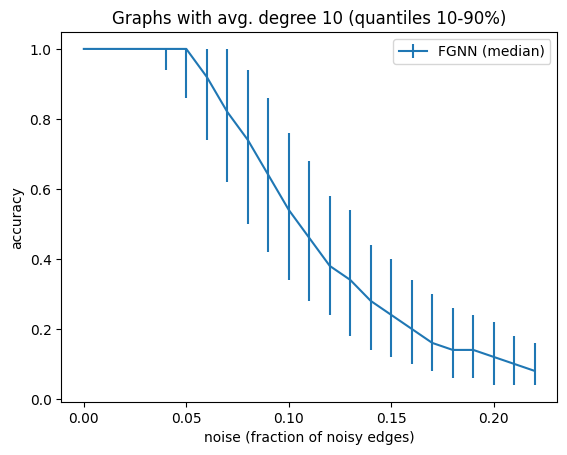

In [14]:
error_50 = acc_2_error(mc_50,q50)

plt.errorbar(list_noise,mc_50,yerr=error_50.T,label='FGNN (median)');
plt.xlabel('noise (fraction of noisy edges)')
plt.ylabel('accuracy')
plt.title(f'Graphs with avg. degree 10 (quantiles {int(100*quant_low)}-{int(100*quant_up)}%)')
plt.legend()
plt.show()